# Average Annual Temperature
***
### Seattle, WA - 1850 thru 2013
#### Examples below:
***

In [1]:
### pep8 statndard
import pyodbc ### SQL port: small-mid result sets
import pandas as pd
import numpy as np
import os ### simple folder navigation
from pathlib import Path ### Windows file path encapsulator
import datetime as dt
from dateutil.relativedelta import relativedelta ### support for multi-granular time incrementation
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline ### configures for inline support
pd.options.display.float_format = '{:.3f}'.format ### default decimal precision
### Pad-out margins
pd.set_option('display.max_columns', None) ### pd.reset_option('max_columns') ### to reset
pd.set_option('display.max_rows', None) ### pd.reset_option('max_rows') ### to reset

<div class="alert alert-block alert-info">
<b>Note:</b> Local folders were addressed in pathlib.Path() function -- omitted here for privacy.</div>

In [3]:
### Load data set into python from local dowload location
dfCity = pd.read_csv(folderstring / 'GlobalLandTemperaturesByCity.csv',low_memory=False)

In [4]:
###Quick look at raw data
dfCity.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [5]:
### Isolate example city
dfCity['dt'] = pd.to_datetime(dfCity['dt'])
dfSeattle = dfCity[(dfCity['City'] == 'Seattle') & (dfCity['dt'] >= '1850-01-01')]
dfSEA = dfSeattle.copy(deep = True).rename(columns = {'AverageTemperature':'AvgTemp', 'AverageTemperatureUncertainty': 'AvgTempVar', 'dt': 'Date'})
dfSEA['Year'] = dfSeattle['dt'].dt.year ### add column for later join/merge
dfSEA.head()

,Date,AvgTemp,AvgTempVar,City,Country,Latitude,Longitude,Year
6830403,1850-01-01,-0.981,1.647,Seattle,United States,47.42N,121.97W,1850
6830404,1850-02-01,1.552,1.346,Seattle,United States,47.42N,121.97W,1850
6830405,1850-03-01,1.261,3.354,Seattle,United States,47.42N,121.97W,1850
6830406,1850-04-01,7.776,4.881,Seattle,United States,47.42N,121.97W,1850
6830407,1850-05-01,10.359,3.442,Seattle,United States,47.42N,121.97W,1850


In [6]:
### Add annual averages
dfSEA_y = dfSEA.groupby(by = [
    'City','Country','Latitude','Longitude']).resample('AS', on = 'Date', label = 'left', closed = 'left').mean().reset_index().rename(columns = {
    'AvgTemp':'AnnlAvgTemp','AvgTempVar':'AnnlAvgTempVar'})
dfSEAw = dfSEA.merge(dfSEA_y[['Year','AnnlAvgTemp','AnnlAvgTempVar']], on = 'Year') ### Merge here
dfSEAw.head()

,Date,AvgTemp,AvgTempVar,City,Country,Latitude,Longitude,Year,AnnlAvgTemp,AnnlAvgTempVar
0,1850-01-01,-0.981,1.647,Seattle,United States,47.42N,121.97W,1850,7.059,2.096
1,1850-02-01,1.552,1.346,Seattle,United States,47.42N,121.97W,1850,7.059,2.096
2,1850-03-01,1.261,3.354,Seattle,United States,47.42N,121.97W,1850,7.059,2.096
3,1850-04-01,7.776,4.881,Seattle,United States,47.42N,121.97W,1850,7.059,2.096
4,1850-05-01,10.359,3.442,Seattle,United States,47.42N,121.97W,1850,7.059,2.096


In [7]:
### Reformat
dfSEAw_l = pd.melt(dfSEAw, id_vars = ['Year','Date','City','Country','Latitude','Longitude']
                   , value_vars = ['AvgTemp','AvgTempVar','AnnlAvgTemp','AnnlAvgTempVar']).rename(columns={'variable':'Measure'})
dfs = dfSEAw_l.copy(deep = True)
dfs['Fahrenheit'] = dfSEAw_l['value'] * 9 / 5 + 32
dfs[dfs['Date'].isin(['2007-06-01','2007-07-01']) ].head(10) ### Lets look at two specific months to verify value types and aggregations

,Year,Date,City,Country,Latitude,Longitude,Measure,value,Fahrenheit
1889,2007,2007-06-01,Seattle,United States,47.42N,121.97W,AvgTemp,12.496,54.493
1890,2007,2007-07-01,Seattle,United States,47.42N,121.97W,AvgTemp,17.112,62.802
3854,2007,2007-06-01,Seattle,United States,47.42N,121.97W,AvgTempVar,0.256,32.461
3855,2007,2007-07-01,Seattle,United States,47.42N,121.97W,AvgTempVar,0.321,32.578
5819,2007,2007-06-01,Seattle,United States,47.42N,121.97W,AnnlAvgTemp,8.038,46.469
5820,2007,2007-07-01,Seattle,United States,47.42N,121.97W,AnnlAvgTemp,8.038,46.469
7784,2007,2007-06-01,Seattle,United States,47.42N,121.97W,AnnlAvgTempVar,0.244,32.440
7785,2007,2007-07-01,Seattle,United States,47.42N,121.97W,AnnlAvgTempVar,0.244,32.440


In [8]:
### Seaborn paramater packing for plots and figures - sets global plotting variables 
rcPack = {'figure.figsize': (12,6),'axes.facecolor':'whitesmoke', 'axes.edgecolor':'lightgrey', 'axes.labelcolor':'dimgrey', 'grid.color':'lightgrey'
    , 'figure.facecolor':'gainsboro', 'text.color':'dimgrey', 'xtick.color':'dimgrey', 'ytick.color':'dimgrey', 'legend.loc':'upper left'}
errPack = {'visible':'True', 'alpha':0.4, 'linestyle':':', 'linewidth':1.2}

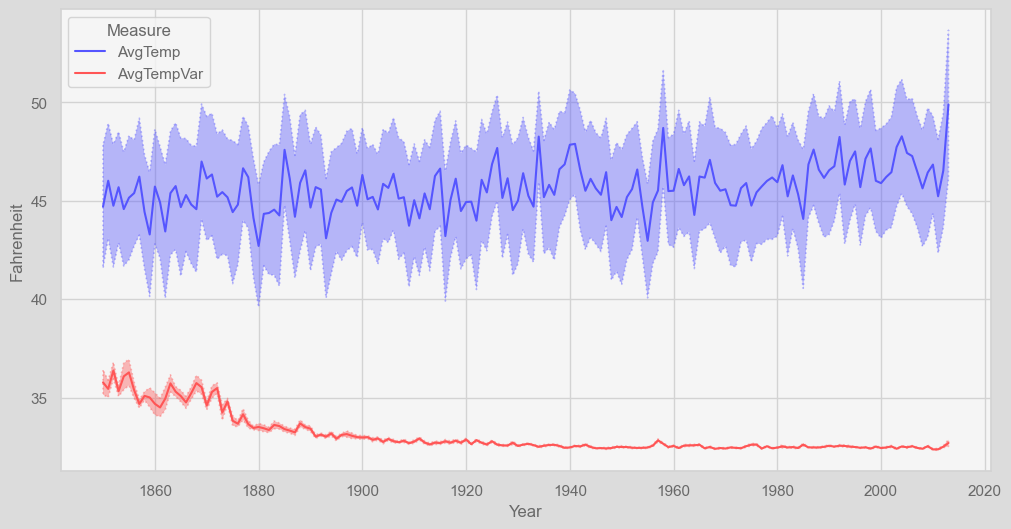

In [9]:
### Simple Lineplot
sns.set_theme()
sns.set(rc=rcPack)
grid = sns.lineplot(data = dfs[dfs['Measure'].isin(['AvgTemp','AvgTempVar'])]
                    , x = 'Year', y ='Fahrenheit', palette = 'seismic', hue = 'Measure', errorbar = ('se',1), err_kws = errPack);